✅ Loaded battery03 (recommissioned) with 2161444 rows
✅ Loaded battery02 (recommissioned) with 2069667 rows
✅ Loaded battery12 (recommissioned) with 3041084 rows
✅ Loaded battery33 (recommissioned) with 2353426 rows
✅ Loaded battery32 (recommissioned) with 1829938 rows
✅ Loaded battery24 (recommissioned) with 3285619 rows
✅ Loaded battery25 (recommissioned) with 2169910 rows
✅ Loaded battery53 (recommissioned) with 1139972 rows
✅ Loaded battery13 (second_life) with 1736149 rows
✅ Loaded battery36 (second_life) with 3394365 rows
✅ Loaded battery54 (second_life) with 1989458 rows


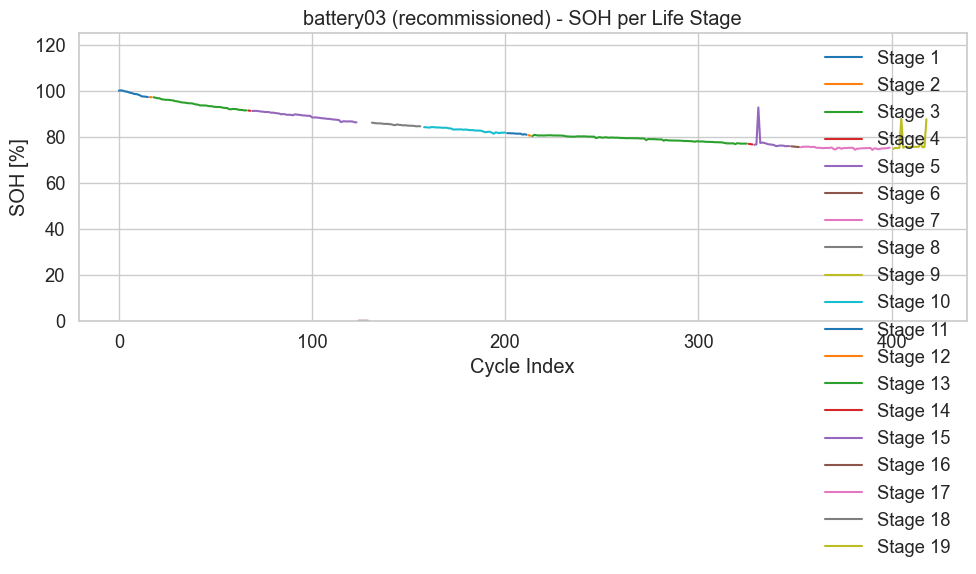

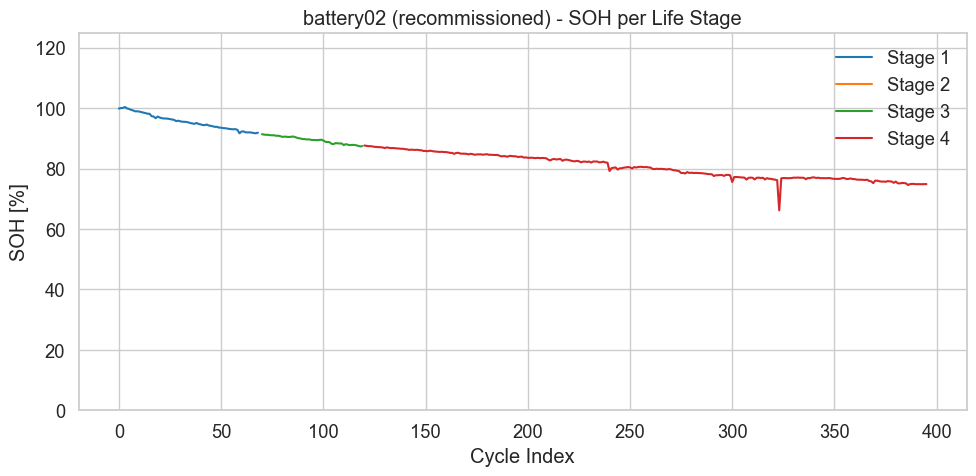

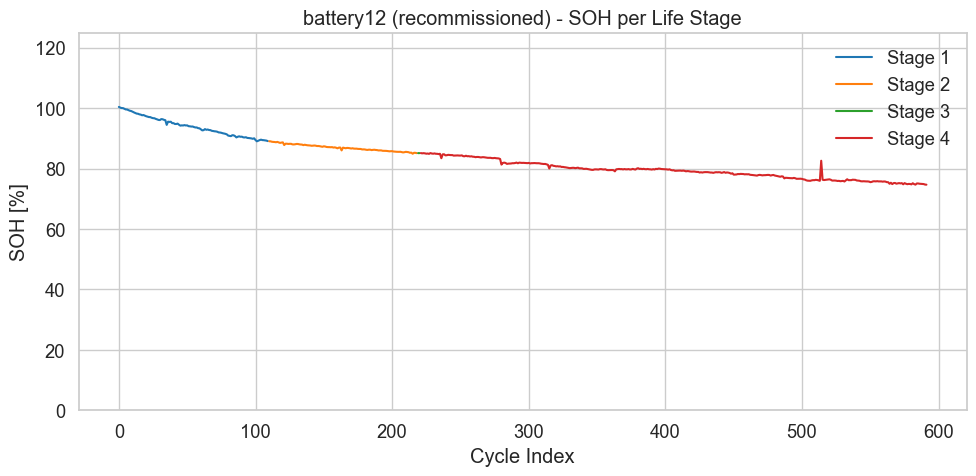

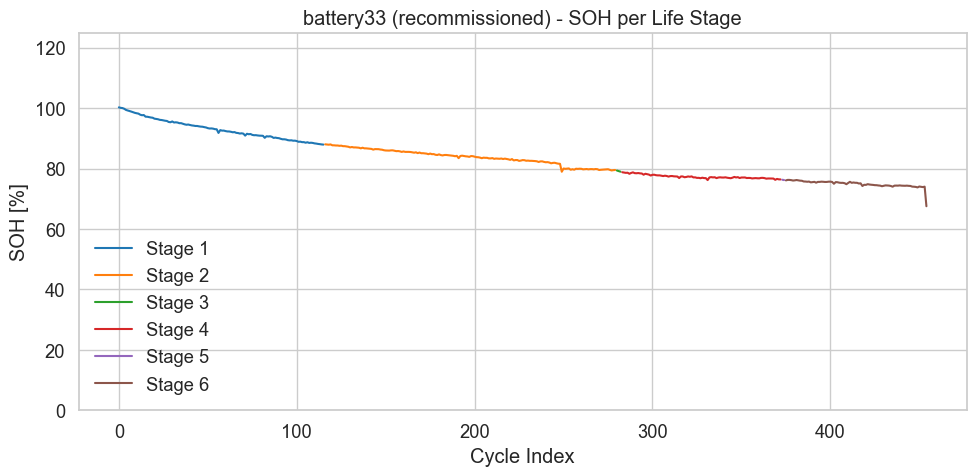

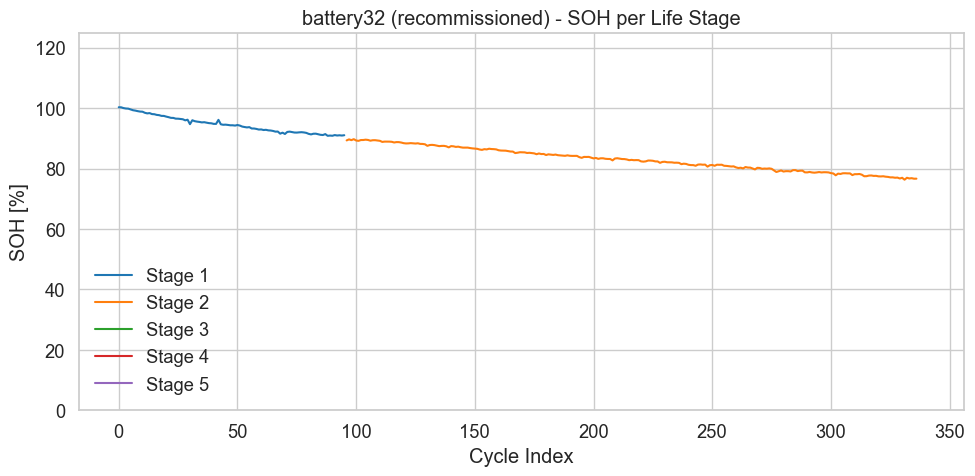

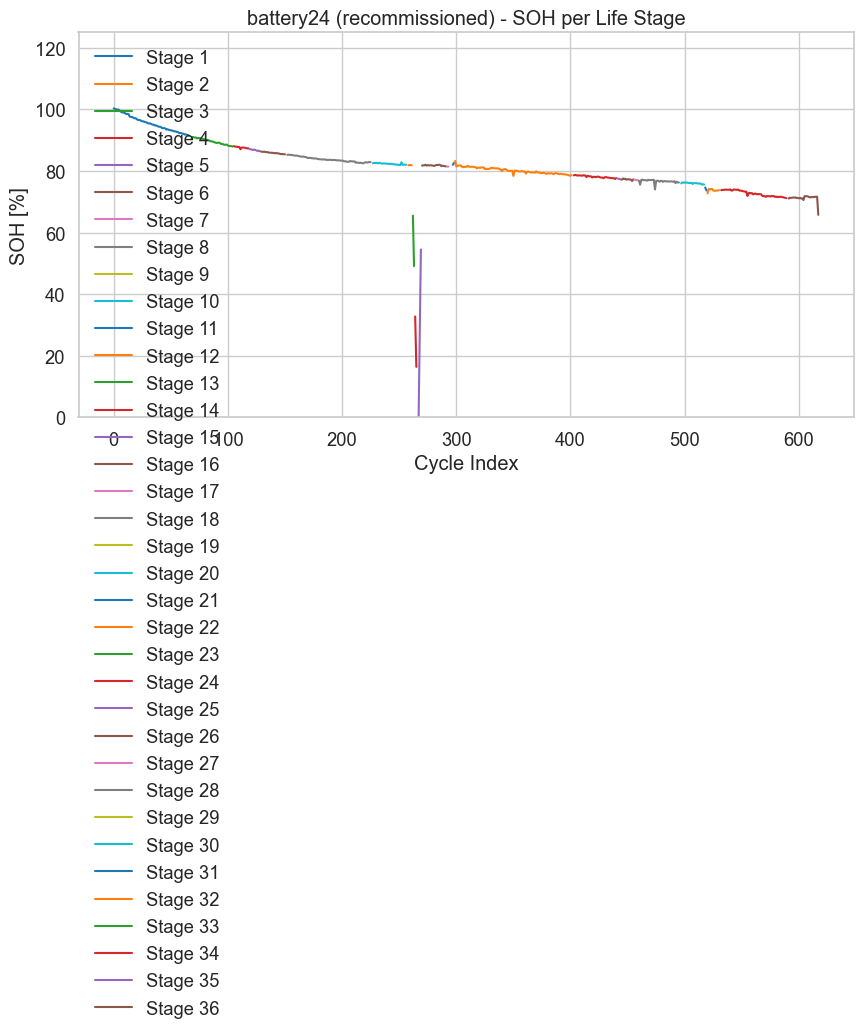

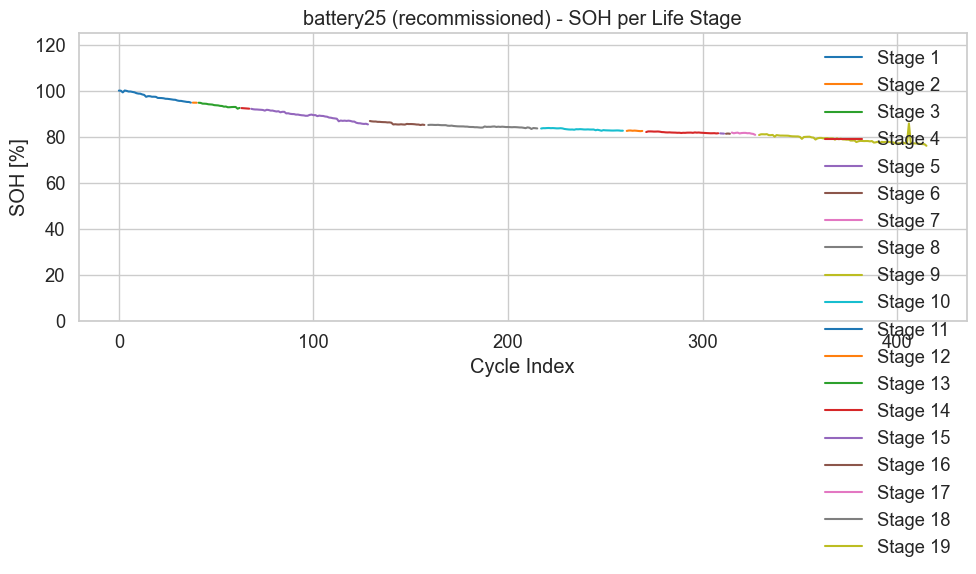

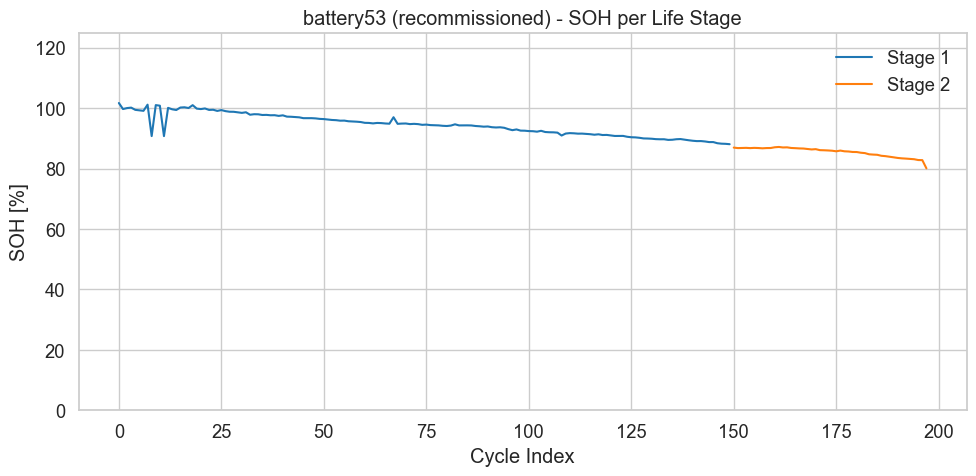

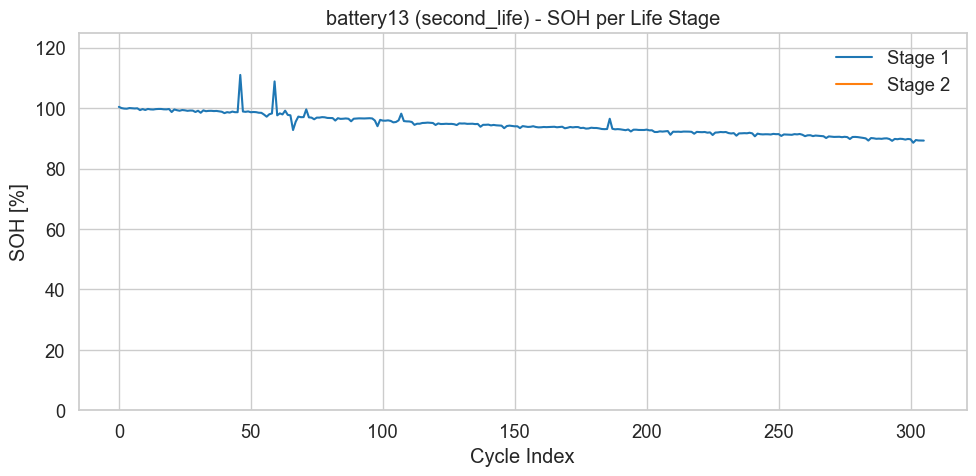

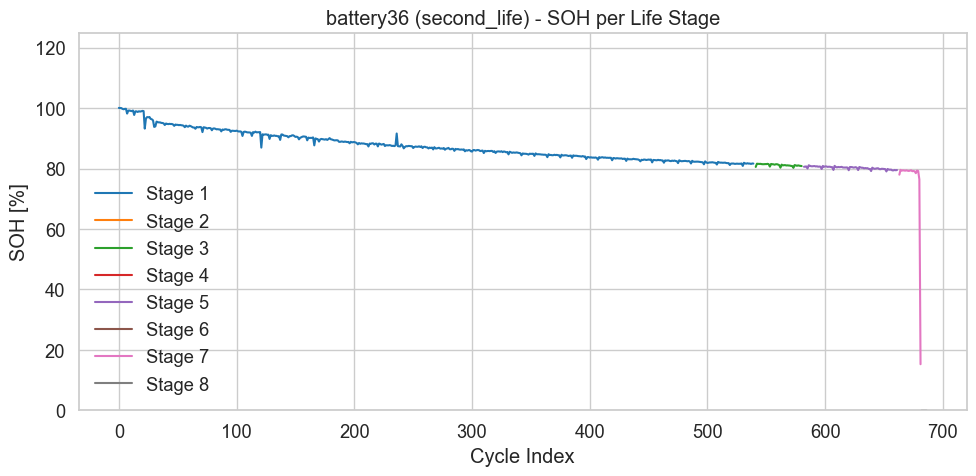

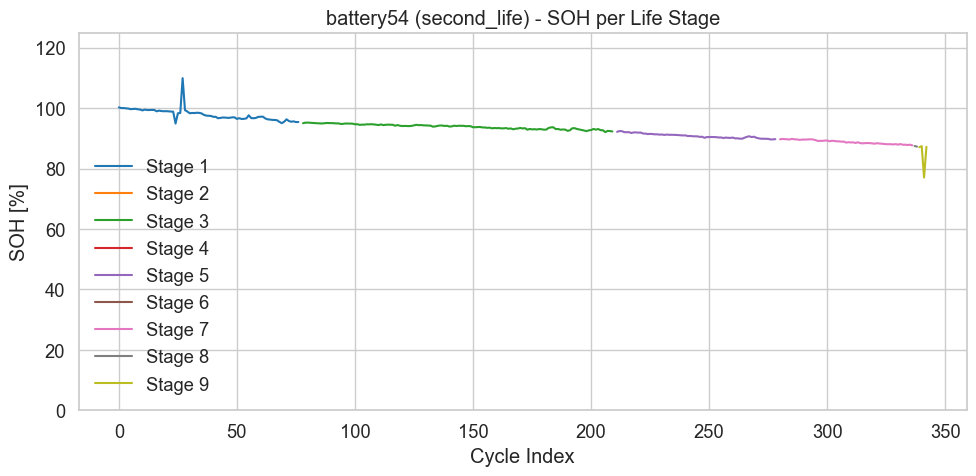

,battery,type,life_stages,initial_capacity,final_capacity,final_soh,discharge_cycles
0,battery36,second_life,8,1.946216,0.000259,0.013334,687
1,battery24,recommissioned,36,2.449718,1.605498,65.739724,618
2,battery33,recommissioned,6,2.453295,1.652373,67.517192,455
3,battery12,recommissioned,4,2.450307,1.822116,74.644502,592
4,battery02,recommissioned,4,2.448645,0.256120,74.848937,396
5,battery25,recommissioned,19,2.472797,1.880027,76.054261,416
6,battery32,recommissioned,5,2.444302,0.000270,76.640342,340
7,battery53,recommissioned,2,2.453080,1.931436,80.053275,198
8,battery54,second_life,9,1.894876,1.648246,87.189360,343
9,battery03,recommissioned,19,2.481707,2.174153,87.607140,419


In [9]:
# recommissioned_and_second_life_analysis.ipynb

# ==========================
# 1. Imports & Config
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from scipy import integrate
from scipy.ndimage import gaussian_filter1d
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

# ==========================
# 2. Paths & Battery Type Detection
# ==========================
RECOM_PATH = "../battery_alt_dataset/recommissioned_batteries"
SECOND_LIFE_PATH = "../battery_alt_dataset/second_life_batteries"

def find_csv_files(*paths):
    all_files = []
    for path in paths:
        all_files += glob.glob(os.path.join(path, "*.csv"))
    return all_files

def label_battery_type(file_path):
    if "recommissioned_batteries" in file_path:
        return "recommissioned"
    elif "second_life_batteries" in file_path:
        return "second_life"
    return "unknown"

csv_files = find_csv_files(RECOM_PATH, SECOND_LIFE_PATH)

# ==========================
# 3. Load Data & Annotate Type
# ==========================
battery_data = {}
battery_metadata = {}

for file_path in csv_files:
    battery_name = os.path.basename(file_path).split('.')[0]
    battery_type = label_battery_type(file_path)
    try:
        df = pd.read_csv(file_path)
        if 'start_time' in df.columns:
            df['start_time'] = pd.to_datetime(df['start_time'])
        battery_data[battery_name] = df
        battery_metadata[battery_name] = {"path": file_path, "type": battery_type}
        print(f"✅ Loaded {battery_name} ({battery_type}) with {len(df)} rows")
    except Exception as e:
        print(f"❌ Error loading {battery_name}: {e}")

# ==========================
# 4. Helper Functions (drop-in from original script)
# ==========================
# Paste fix_malformed_columns, preprocess_battery_data, calculate_soh_features here

# ==========================
# 5. Process Batteries
# ==========================
processed_data = {}
cycle_info = {}
soh_data = {}

for battery_name, df in battery_data.items():
    processed_df, cycles = preprocess_battery_data(df)
    if cycles.empty:
        continue
    processed_data[battery_name] = processed_df
    cycle_info[battery_name] = cycles
    soh_df = calculate_soh_features(battery_name, cycles)
    if soh_df is not None:
        soh_data[battery_name] = soh_df

# ==========================
# 6. Tag Life Stages (based on current profile)
# ==========================
def tag_life_stages(df, threshold=1.5):
    if 'avg_discharge_current' not in df.columns:
        df['stage'] = 1
        return df

    shifts = df['avg_discharge_current'].diff().abs() > threshold
    stage_id = 1
    stage_col = []

    for i in range(len(shifts)):
        if i == 0:
            stage_col.append(stage_id)
        elif shifts.iloc[i]:
            stage_id += 1
            stage_col.append(stage_id)
        else:
            stage_col.append(stage_id)

    df['stage'] = stage_col
    return df

for battery in soh_data:
    soh_data[battery] = tag_life_stages(soh_data[battery])

# ==========================
# 7. Stage-Aware SOH Plot
# ==========================
def plot_soh_per_stage(soh_data):
    for battery, df in soh_data.items():
        if 'cycle_index' not in df.columns or 'soh_percentage' not in df.columns:
            continue
        battery_type = battery_metadata.get(battery, {}).get('type', 'unknown')
        plt.figure(figsize=(10, 5))
        for stage, group in df.groupby('stage'):
            plt.plot(group['cycle_index'], group['soh_percentage'], label=f"Stage {stage}")
        plt.xlabel("Cycle Index")
        plt.ylabel("SOH [%]")
        plt.title(f"{battery} ({battery_type}) - SOH per Life Stage")
        plt.ylim(0, 125)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_soh_per_stage(soh_data)

# ==========================
# 8. Summary Table with Type
# ==========================
summary = []
for battery, df in soh_data.items():
    if df.empty or 'discharge_capacity_ah' not in df.columns:
        continue
    summary.append({
        "battery": battery,
        "type": battery_metadata.get(battery, {}).get("type", "unknown"),
        "life_stages": df['stage'].nunique() if 'stage' in df.columns else 1,
        "initial_capacity": df['discharge_capacity_ah'].iloc[0],
        "final_capacity": df['discharge_capacity_ah'].iloc[-1],
        "final_soh": df['soh_percentage'].iloc[-1],
        "discharge_cycles": len(df)
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("final_soh")
summary_df.reset_index(drop=True, inplace=True)
display(summary_df)
